## IMPORT LIBRARIES

In [1]:
# data wrangling 

import pandas as pd
import numpy as np
import re

# data visualization

import matplotlib.pyplot as plt
import seaborn as sns

# feature engineering

import scipy.stats as ss
import statsmodels.api as sm
from scipy.stats import anderson, mannwhitneyu, chi2_contingency
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score

# models

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KernelDensity, KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# model evaluation

import joblib
from yellowbrick.model_selection import learning_curve, ValidationCurve
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score, f1_score, log_loss, precision_score, recall_score
from sklearn.datasets import make_classification

# filter warning

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=FutureWarning)

## OVERVIEW

In [2]:
# load data

df = pd.read_csv('data_hujan_full.csv')

In [3]:
# show top 5

df.head()

,convective_available_potential_energy,k_index,cross_totals_index,vertical_totals_index,lifted_index,showalter_index,temp_1000_hpa,dewpoint_1000_hpa,temp_850_hpa,dewpoint_850_hpa,temp_700_hpa,dewpoint_700_hpa,temp_500_hpa,dewpoint_500_hpa,rain
0,508.22,35.4,20.1,22.9,-1.48,0.16,27.0,22.2,18.6,15.8,10.2,6.9,-4.3,11.3,0
1,508.22,35.4,20.1,22.9,-1.48,0.16,27.0,22.2,18.6,15.8,10.2,6.9,-4.3,11.3,0
2,952.96,32.2,19.2,22.1,-2.35,1.33,26.2,23.5,18.0,15.1,11.0,6.0,-4.1,26.1,0
3,952.96,32.2,19.2,22.1,-2.35,1.33,26.2,23.5,18.0,15.1,11.0,6.0,-4.1,26.1,0
4,276.15,33.7,17.1,23.1,-0.87,2.82,26.2,22.1,19.0,13.0,9.0,6.6,-4.1,34.1,0


In [4]:
# check info on initial data

pd.DataFrame({'Features' : df.columns, 'dataType' : df.dtypes.values, 
              'nullvalues' : [df[i].isna().sum() for i in df.columns],
              'unique' : [df[i].nunique() for i in df.columns],
              'uniqueSample' : [list(pd.Series(df[i].unique()).sample()) for i in df.columns]}).reset_index(drop = True)

,Features,dataType,nullvalues,unique,uniqueSample
0,convective_available_potential_energy,float64,0,967,[8.23]
1,k_index,float64,0,303,[28.4]
2,cross_totals_index,float64,0,135,[-6.3]
3,vertical_totals_index,float64,0,42,[23.9]
4,lifted_index,float64,0,644,[-2.91]
5,showalter_index,float64,0,645,[8.19]
6,temp_1000_hpa,float64,0,34,[28.6]
7,dewpoint_1000_hpa,float64,0,95,[21.4]
8,temp_850_hpa,float64,0,33,[20.8]
9,dewpoint_850_hpa,float64,0,135,[8.8]


## FEATURE ENGINEERING

In [5]:
# Split target features

X = df.drop(['rain'], axis=1)
y = df['rain']

In [6]:
# show X & y data

print(X,y)

      convective_available_potential_energy  k_index  cross_totals_index  \
0                                    508.22     35.4                20.1   
1                                    508.22     35.4                20.1   
2                                    952.96     32.2                19.2   
3                                    952.96     32.2                19.2   
4                                    276.15     33.7                17.1   
...                                     ...      ...                 ...   
2539                                 236.40     34.5                21.5   
2540                                 706.46     30.5                19.1   
2541                                 706.46     30.5                19.1   
2542                                 119.45     32.4                18.8   
2543                                 119.45     32.4                18.8   

      vertical_totals_index  lifted_index  showalter_index  temp_1000_hpa  \
0         

In [7]:
# scale X features using RobustScaler

for i in X :
    scaler = RobustScaler()
    X[i] = scaler.fit_transform(X[i].values.reshape(-1,1))

## MODEL PREPARATION

In [8]:
# function to calculate metrics

def calc_train(X_train, y_train, model):
    predictions = model.predict(X_train)
    f1 = f1_score(y_train, predictions, average ='weighted')
    accuracy = accuracy_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    recall = recall_score(y_train,predictions)
    return{
        'f1_score' : f1,
        'accuracy': accuracy,
        'precision': precision,
        'recall' : recall 
    }

def calc_test(X_test, y_test, model):
    predictions = model.predict(X_test)
    f1 = f1_score(y_test, predictions, average ='weighted')
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test,predictions)
    return{
        'f1_score' : f1,
        'accuracy': accuracy,
        'precison': precision,
        'recall' : recall
    }

def calc_metrics(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    train_score = calc_train(X_train, y_train, model)
    test_score = calc_test(X_test, y_test, model)
    return (train_score, test_score)

In [9]:
# setting multi-classification model with tuned parameter

model_RFC = RandomForestClassifier(n_estimators = 1000, min_samples_split = 10, min_samples_leaf = 8, max_depth = 20)
model_XGB = XGBClassifier(reg_lambda = 1, reg_alpha = 40, n_estimators = 180, min_child_weight = 0, max_depth = 5, gamma = 2, colsample_bytree = 0.5)

model_list = [model_RFC, model_XGB]

In [10]:
# calculate model scores

for i in range(0, len(model_list)):    
    def pipeline_scores(X_train, X_test, y_train, y_test):
        train_scores = []
        test_scores = []
        for j in model_list:
            train_score, test_score = calc_metrics(X_train, y_train, X_test, y_test, j)
            train_scores.append(train_score)
            test_scores.append(test_score)
            scores = {'train' : train_scores, 'test': test_scores}
        return scores

## MODELLING WITH OVERSAMPLED DATA

In [11]:
# split train, test data

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

In [12]:
# function to automate oversampling 

def modelscore(X_train, y_train, X_test, y_test, model_name, scoring):

    X_train_sm, y_train_sm = SMOTE(random_state = 42).fit_sample(X_train, y_train)

    model_list_sm = [i.fit(X_train_sm, y_train_sm) for i in model_list]
    
    report_sm = pipeline_scores(X_train_sm, X_test, y_train_sm, y_test)
    
    model = list(model_name)
    for i in range(0, len(model)):
        print('TRAIN', model[i], '\n', report_sm['train'][i])
        print('TEST ', model[i], '\n', report_sm['test'][i])
        print('\n')
        
    kfold = []
    for i in range(0, len(model)):
        cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)
        fold = cross_val_score(model_list_sm[i], X_train_sm, y_train_sm, cv = cv, scoring = str(scoring))
        kfold.append(fold.mean())
        
    Xtrain_score = []
    kfold_score = []

    for i in range(0, len(kfold)):
        kfold_score.append(kfold[i])
        Xtrain_score.append(report_sm['train'][i]['recall'])

        print(model[i])
        print('Train Score : ', Xtrain_score[i], '| Kfold Score : ', kfold_score[i], '\n')
    
    conf_matrix = []
    for i in range(0, (len(model_list_sm))):
        labels = ['Not Rain', 'Rain']
        y_pred = model_list_sm[i].predict(X_test)
        conf_matrix.append(confusion_matrix(y_test, y_pred))
        print('\n',model[i],'\n', classification_report(y_test, y_pred, target_names = labels))

In [13]:
# check model stats and score

model_name = 'Random Forest', 'XGBoost'
modelscore(X_train, y_train, X_test, y_test, model_name, 'recall')

TRAIN Random Forest 
 {'f1_score': 0.8769839123942496, 'accuracy': 0.8770848440899203, 'precision': 0.8566529492455418, 'recall': 0.90572878897752}
TEST  Random Forest 
 {'f1_score': 0.739580849936991, 'accuracy': 0.7367387033398821, 'precison': 0.6255924170616114, 'recall': 0.7058823529411765}


TRAIN XGBoost 
 {'f1_score': 0.7415022275672195, 'accuracy': 0.7443799854967368, 'precision': 0.7017964071856287, 'recall': 0.8498912255257433}
TEST  XGBoost 
 {'f1_score': 0.6968835742238181, 'accuracy': 0.6915520628683693, 'precison': 0.556390977443609, 'recall': 0.7914438502673797}


Random Forest
Train Score :  0.90572878897752 | Kfold Score :  0.8049032053316407 

XGBoost
Train Score :  0.8498912255257433 | Kfold Score :  0.8281180577594414 


 Random Forest 
               precision    recall  f1-score   support

    Not Rain       0.82      0.75      0.78       322
        Rain       0.63      0.71      0.66       187

    accuracy                           0.74       509
   macro avg  

## FEATURE ENGINEERING - FEATURE SELECTION

[0.06603774 0.08983468 0.07186907 0.06520268 0.07974108 0.08385083
 0.05797096 0.09085845 0.05854325 0.08808601 0.05304268 0.06200569
 0.05326625 0.07969063]


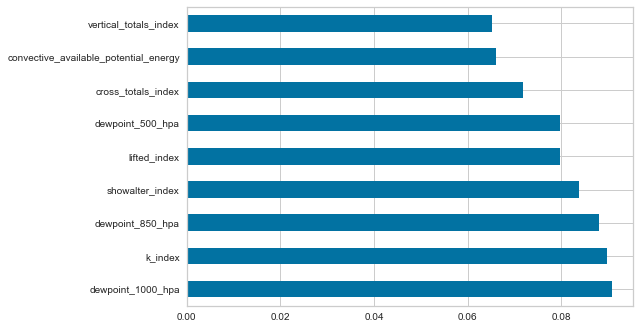

In [14]:
# feature importances using Tree Based Classifier

tree = ExtraTreesClassifier()
tree.fit(X,y)
print(tree.feature_importances_)

# plot graph of feature importances for better visualization

feat_importances = pd.Series(tree.feature_importances_, index=X.columns)
feat_importances.nlargest(9).plot(kind = 'barh')
plt.show()

In [15]:
# get new columns from feature importances

feat_col = feat_importances.nlargest(9).index.tolist()
feat_tgt = pd.DataFrame(df['rain'])

In [16]:
# get new dataframe

df_new = pd.concat([df[feat_col], feat_tgt], axis=1)

In [17]:
# show top 3 

df_new.head(3)

,dewpoint_1000_hpa,k_index,dewpoint_850_hpa,showalter_index,lifted_index,dewpoint_500_hpa,cross_totals_index,convective_available_potential_energy,vertical_totals_index,rain
0,22.2,35.4,15.8,0.16,-1.48,11.3,20.1,508.22,22.9,0
1,22.2,35.4,15.8,0.16,-1.48,11.3,20.1,508.22,22.9,0
2,23.5,32.2,15.1,1.33,-2.35,26.1,19.2,952.96,22.1,0


## MODELLING WITH SELECTED FEATURE AND OVERSAMPLED DATA

In [18]:
# split target feature

X1 = df_new.drop(columns=['rain'], axis = 1)
y1 = df_new['rain']

In [19]:
# scale X features using RobustScaler

for i in X1 :
    scaler = RobustScaler()
    X1[i] = scaler.fit_transform(X1[i].values.reshape(-1,1))

In [20]:
# split train, test data 

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, train_size = 0.8, random_state = 42)

In [21]:
# check model stats and score

model_name = 'Random Forest', 'XGBoost'
modelscore(X1_train, y1_train, X1_test, y1_test, model_name, 'recall')

TRAIN Random Forest 
 {'f1_score': 0.8722691198450624, 'accuracy': 0.8723712835387962, 'precision': 0.8524365133836651, 'recall': 0.9006526468455403}
TEST  Random Forest 
 {'f1_score': 0.7188270882834534, 'accuracy': 0.7151277013752456, 'precison': 0.5963302752293578, 'recall': 0.6951871657754011}


TRAIN XGBoost 
 {'f1_score': 0.7321359482479991, 'accuracy': 0.734590282813633, 'precision': 0.696895922093731, 'recall': 0.8303118201595359}
TEST  XGBoost 
 {'f1_score': 0.6815832394858901, 'accuracy': 0.6758349705304518, 'precison': 0.5423076923076923, 'recall': 0.7540106951871658}


Random Forest
Train Score :  0.9006526468455403 | Kfold Score :  0.8012747275997038 

XGBoost
Train Score :  0.8303118201595359 | Kfold Score :  0.8259229874114038 


 Random Forest 
               precision    recall  f1-score   support

    Not Rain       0.80      0.73      0.76       322
        Rain       0.60      0.70      0.64       187

    accuracy                           0.72       509
   macro a

## MODEL TESTING AND DEPLOYMENT

In [22]:
# Model Best Parameter

model1  = model_XGB
model2  = model_RFC
y_pred1 = model1.predict(X1_test)
y_pred2 = model2.predict(X1_test)

              precision    recall  f1-score   support

    Not Rain       0.82      0.63      0.71       322
        Rain       0.54      0.75      0.63       187

    accuracy                           0.68       509
   macro avg       0.68      0.69      0.67       509
weighted avg       0.71      0.68      0.68       509



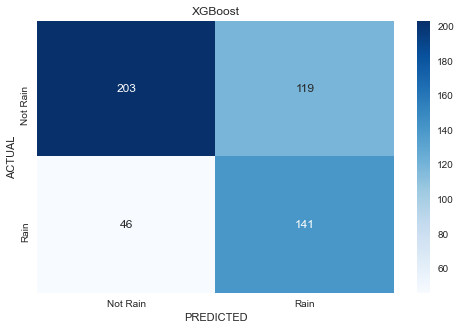

In [23]:
# XGB Model evaluation

labels = ['Not Rain', 'Rain']
print(classification_report(y1_test, y_pred1, target_names = labels))
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y1_test, y_pred1), annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.title('XGBoost')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.show()

              precision    recall  f1-score   support

    Not Rain       0.80      0.73      0.76       322
        Rain       0.60      0.70      0.64       187

    accuracy                           0.72       509
   macro avg       0.70      0.71      0.70       509
weighted avg       0.73      0.72      0.72       509



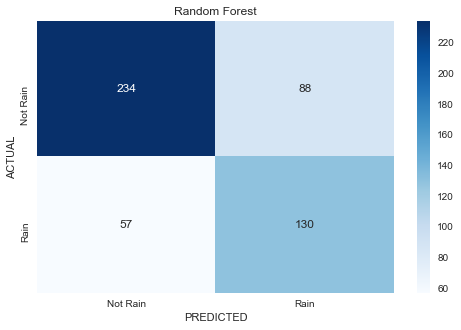

In [24]:
# RFC Model evaluation

labels = ['Not Rain', 'Rain']
print(classification_report(y1_test, y_pred2, target_names = labels))
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y1_test, y_pred2), annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.title('Random Forest')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.show()

In [25]:
# split rain and not rain

rain_no  = df_new[df_new['rain']==0].tail().drop(columns = ['rain'], axis = 1).T
rain_yes = df_new[df_new['rain']==1].tail().drop(columns = ['rain'], axis = 1).T

In [26]:
# show not rain data

rain_no

,2533,2538,2539,2540,2542
dewpoint_1000_hpa,20.60,22.20,22.20,22.10,21.20
k_index,29.30,34.50,34.50,30.50,32.40
dewpoint_850_hpa,12.00,15.20,15.20,14.20,13.70
showalter_index,3.52,-0.49,-0.49,1.20,1.38
lifted_index,-0.02,-2.26,-2.26,-2.39,-0.87
dewpoint_500_hpa,16.30,-8.30,-8.30,-8.40,10.00
cross_totals_index,16.30,21.50,21.50,19.10,18.80
convective_available_potential_energy,130.72,236.40,236.40,706.46,119.45
vertical_totals_index,23.30,23.30,23.30,23.30,23.70


In [27]:
# show rain data

rain_yes

,2535,2536,2537,2541,2543
dewpoint_1000_hpa,19.40,20.80,21.60,22.10,21.20
k_index,29.90,33.80,29.30,30.50,32.40
dewpoint_850_hpa,13.00,14.50,12.20,14.20,13.70
showalter_index,2.52,-0.56,1.64,1.20,1.38
lifted_index,1.42,-1.89,-2.03,-2.39,-0.87
dewpoint_500_hpa,19.90,-8.70,10.00,-8.40,10.00
cross_totals_index,17.90,20.40,18.10,19.10,18.80
convective_available_potential_energy,0.00,336.26,283.34,706.46,119.45
vertical_totals_index,22.90,25.30,25.10,23.30,23.70


In [37]:
# XGB
# predict not rain

for i in rain_no :
    rain_no[i] = rain_no[i].ravel().tolist()
    pred = round(model1.predict_proba(rain_no[i].values.reshape(1,-1))[0][0]*100, 2)
    if pred > 50 :
        print(f'Rain Probability is {pred}% - it will be Rain')
    else :
        print(f'Rain Probability is {pred}% - it will not Rain')

Rain Probability is 50.94% - it will be Rain
Rain Probability is 48.57% - it will not Rain
Rain Probability is 48.57% - it will not Rain
Rain Probability is 50.0% - it will not Rain
Rain Probability is 50.0% - it will not Rain


In [31]:
# XGB
# predict rain

for i in rain_yes :
    rain_yes[i] = rain_yes[i].ravel().tolist()
    pred = round(model1.predict_proba(rain_yes[i].values.reshape(1,-1))[0][1]*100, 2)
    if pred > 50 :
        print(f'Rain Probability is {pred}% - it will be Rain')
    else :
        print(f'Rain Probability is {pred}% - it will not Rain')

Rain Probability is 46.89% - it will not Rain
Rain Probability is 51.43% - it will be Rain
Rain Probability is 50.0% - it will not Rain
Rain Probability is 50.0% - it will not Rain
Rain Probability is 50.0% - it will not Rain


In [36]:
# RFC
# predict not rain

for i in rain_no :
    rain_no[i] = rain_no[i].ravel().tolist()
    pred = round(model2.predict_proba([rain_no[i]])[0][0]*100, 2)
    if pred > 50 :
        print(f'Rain Probability is {pred}% - it will be Rain')
    else :
        print(f'Rain Probability is {pred}% - it will not Rain')

Rain Probability is 52.36% - it will be Rain
Rain Probability is 43.35% - it will not Rain
Rain Probability is 43.35% - it will not Rain
Rain Probability is 46.61% - it will not Rain
Rain Probability is 48.57% - it will not Rain


In [33]:
# RFC
# predict rain

for i in rain_yes :
    rain_yes[i] = rain_yes[i].ravel().tolist()
    pred = round(model2.predict_proba([rain_yes[i]])[0][1]*100, 2)
    if pred > 50 :
        print(f'Rain Probability is {pred}% - it will be Rain')
    else :
        print(f'Rain Probability is {pred}% - it will not Rain')

Rain Probability is 39.96% - it will not Rain
Rain Probability is 56.44% - it will be Rain
Rain Probability is 52.58% - it will be Rain
Rain Probability is 53.39% - it will be Rain
Rain Probability is 51.43% - it will be Rain


> Summary : 

> **Random Forest Classifier** with tuned parameter and oversampled data seems more balanced regarding the recall of the rain and not rain, this model seems also having a better overall performances compared to **XGBoost**, and credible to predict the probability of this features. Therefore I'll dump this model instead.

In [28]:
# drop data to new dataframe

df_new.to_csv('df_model6.csv', index=False)

In [35]:
# dump model with joblib

joblib.dump(model2, 'model_RFC')

['model_RFC']